In [1]:
library(dada2) 
set.seed(100)
getwd()

Loading required package: Rcpp



[1] "/beta/Metabarcoding_curso/leandro3"

In [2]:
path <- '/beta/Metabarcoding_curso/leandro3/secuencias/'

In [3]:
fnFs <- sort(list.files(path, pattern="R1_001.fastq", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="R2_001.fastq", full.names = TRUE))

In [4]:
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)

In [5]:
sample.names

[1] "01.Chilca"     "02.SanMateo"   "03.Tamboraque" "04.PteNuevo"  
[5] "05.PteFaucett" "06.PteGambeta"

In [6]:
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "filtered", paste0(sample.names, "_R_filt.fastq.gz"))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


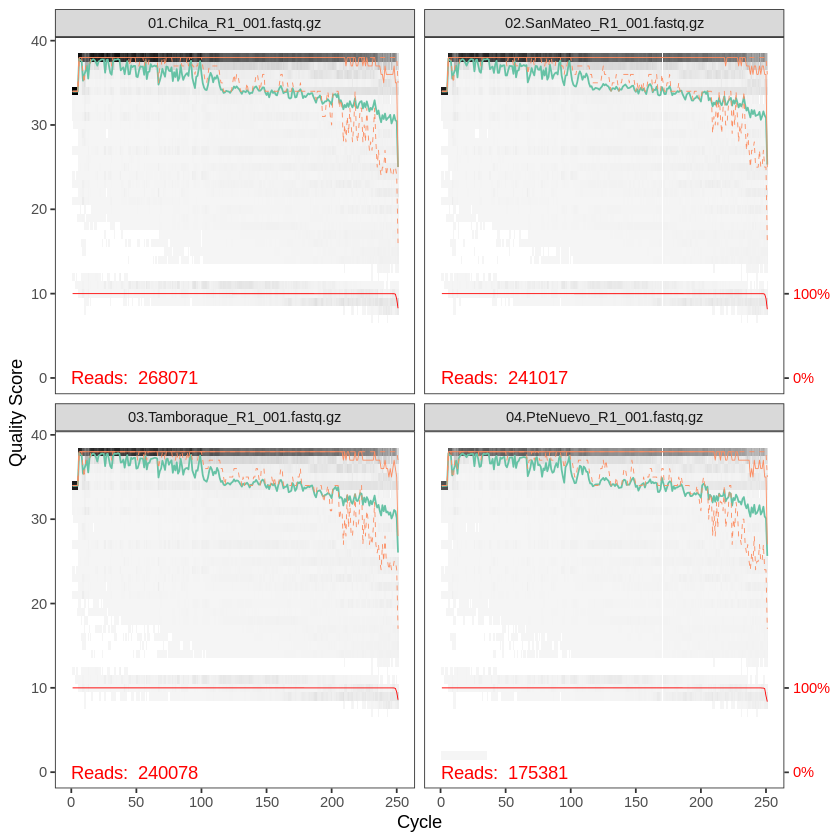

In [7]:
plotQualityProfile(fnFs[1:4])

In [8]:
out <- filterAndTrim(fnFs, filtFs, 
                     fnRs, filtRs,
                     maxEE = c(2,2), rm.phix=TRUE,
                     truncLen = c(250,225),
                     trimLeft = c(17,21), multithread = TRUE)

In [9]:
errF <- learnErrors(filtFs, multithread = TRUE, verbose = TRUE)
errR <- learnErrors(filtRs, multithread = TRUE, verbose = TRUE)

123815035 total bases in 531395 reads from 3 samples will be used for learning the error rates.
Initializing error rates to maximum possible estimate.
selfConsist step 1 ...
   selfConsist step 2
   selfConsist step 3
   selfConsist step 4
   selfConsist step 5
   selfConsist step 6
   selfConsist step 7
   selfConsist step 8
   selfConsist step 9
Convergence after  9  rounds.
108404580 total bases in 531395 reads from 3 samples will be used for learning the error rates.
Initializing error rates to maximum possible estimate.
selfConsist step 1 ...
   selfConsist step 2
   selfConsist step 3
   selfConsist step 4
   selfConsist step 5
   selfConsist step 6
Convergence after  6  rounds.


In [10]:
dadaFs <- dada(filtFs, err=errF, multithread = TRUE)
dadaRs <- dada(filtRs, err=errR, multithread = TRUE)

Sample 1 - 187005 reads in 79000 unique sequences.
Sample 2 - 172971 reads in 71935 unique sequences.
Sample 3 - 171419 reads in 79051 unique sequences.
Sample 4 - 119688 reads in 49285 unique sequences.
Sample 5 - 183048 reads in 67648 unique sequences.
Sample 6 - 148934 reads in 52925 unique sequences.
Sample 1 - 187005 reads in 58780 unique sequences.
Sample 2 - 172971 reads in 58194 unique sequences.
Sample 3 - 171419 reads in 58578 unique sequences.
Sample 4 - 119688 reads in 38667 unique sequences.
Sample 5 - 183048 reads in 53565 unique sequences.
Sample 6 - 148934 reads in 45344 unique sequences.


In [11]:
mergers <- mergePairs(dadaFs, filtFs, dadaRs, filtRs, verbose=TRUE)

81305 paired-reads (in 2654 unique pairings) successfully merged out of 169614 (in 37074 pairings) input.

78456 paired-reads (in 2602 unique pairings) successfully merged out of 155783 (in 31739 pairings) input.

79415 paired-reads (in 3830 unique pairings) successfully merged out of 154144 (in 38495 pairings) input.

41542 paired-reads (in 1139 unique pairings) successfully merged out of 110396 (in 23910 pairings) input.

67640 paired-reads (in 1885 unique pairings) successfully merged out of 170889 (in 34118 pairings) input.

61442 paired-reads (in 1464 unique pairings) successfully merged out of 138650 (in 23768 pairings) input.



In [12]:
seqtab <- makeSequenceTable(mergers)


 236  259  260  303  335  343  372  374  375  378  381  382  383  384  385  386 
   1    1    2    2    4    3    2    2    1    1    2    1    1    3    1    2 
 387  388  390  395  397  398  399  401  402  403  404  405  406  407  408  409 
   3    1    1    1    5    2    2   85 1904  204  223  430  625  171   15   25 
 410  411  412  413  414  415  416  417  418  419  420  421  422  423  424  425 
   1    6    2    4    4    3    2    8    1   52   36  429 5087  122   18   49 

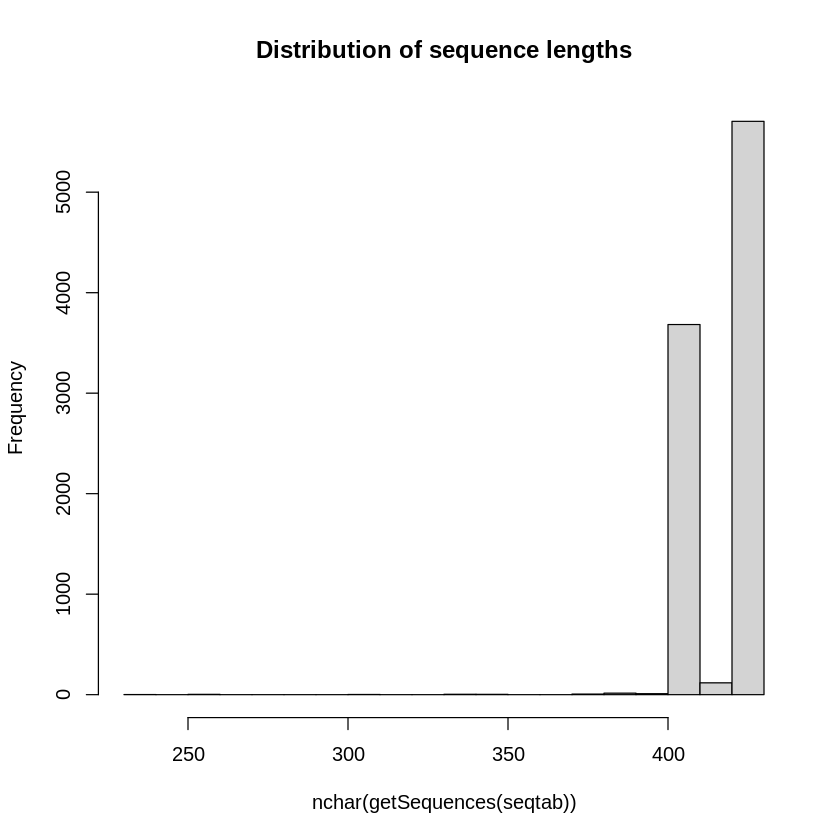

In [13]:
table(nchar(getSequences(seqtab)))
hist(nchar(getSequences(seqtab)), main="Distribution of sequence lengths")

In [14]:
seqtab2 <- seqtab[,nchar(colnames(seqtab)) %in% 400:424]


 401  402  403  404  405  406  407  408  409  410  411  412  413  414  415  416 
  85 1904  204  223  430  625  171   15   25    1    6    2    4    4    3    2 
 417  418  419  420  421  422  423  424 
   8    1   52   36  429 5087  122   18 

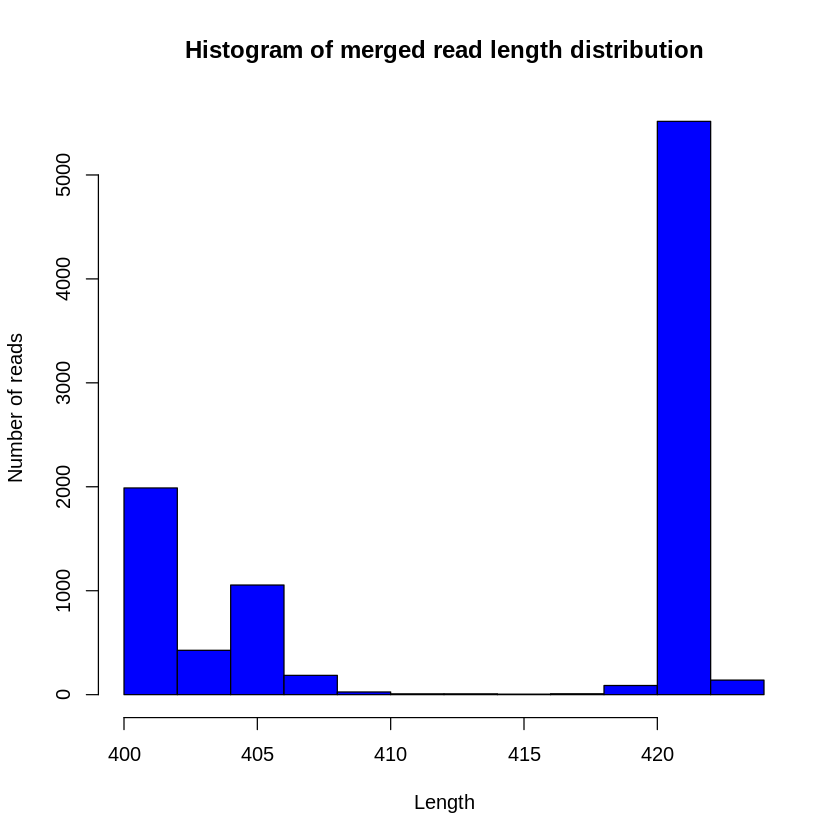

In [15]:
table(nchar(getSequences(seqtab2)))
hist(nchar(getSequences(seqtab2)), main = "Histogram of merged read length distribution", 
     xlab = "Length", ylab = "Number of reads", col = "blue")

In [16]:
seqtab.nochim <- removeBimeraDenovo(seqtab2, method="consensus", multithread=TRUE, verbose=TRUE)
sum(seqtab.nochim)/sum(seqtab2)

Identified 6418 bimeras out of 9457 input sequences.



[1] 0.8441101

In [17]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nonchim")
rownames(track) <- sample.names
View(track)
write.table(x = track, file = "reads-stats.txt", sep = "\t", quote = FALSE)

,input,filtered,denoisedF,denoisedR,merged,nonchim
01.Chilca,268071,187005,175944,177807,81305,69200
02.SanMateo,241017,172971,162306,163358,78456,66856
03.Tamboraque,240078,171419,160451,162402,79415,60757
04.PteNuevo,175381,119688,113671,114816,41542,36985
05.PteFaucett,247658,183048,175359,176555,67640,57601
06.PteGambeta,200529,148934,142589,143046,61442,53945


In [21]:
taxSilva <- assignTaxonomy(seqtab.nochim, 'databases/silva_nr_v138_train_set.fa.gz', multithread=TRUE, minBoot = 80, tryRC=TRUE)

In [23]:
speciesSilva <- addSpecies(taxSilva, 'databases/silva_species_assignment_v138.fa.gz', tryRC = TRUE, n = 10000)

In [24]:
saveRDS(seqtab.nochim, "16sall.rds")
save.image("16s_course.RData")

In [25]:
write.table(taxSilva, file = "taxSilva.tsv", sep = "\t")
write.table(speciesSilva, file = "speciesSilva.tsv", sep = "\t")

In [26]:
asv_seqs <- colnames(seqtab.nochim)
asv_headers <- vector(dim(seqtab.nochim)[2], mode="character")
for (i in 1:dim(seqtab.nochim)[2]) {
  asv_headers[i] <- paste(">ASV", i, sep="_")
}
     

In [27]:
asv_tax <- taxSilva
row.names(asv_tax) <- sub(">", "", asv_headers)
write.table(asv_tax, "ASVs_taxonomy.nov.tsv", sep="\t", quote=F, col.names=NA)

In [28]:
asv_tax_sp <- speciesSilva
row.names(asv_tax_sp) <- sub(">", "", asv_headers)
write.table(asv_tax_sp, "ASVs_taxonomy_sp.nov.tsv", sep="\t", quote=F, col.names=NA)

In [29]:
asv_fasta <- c(rbind(asv_headers, asv_seqs))
write(asv_fasta, "ASVs.nov.fa")

In [30]:
asv_tab <- t(seqtab.nochim)
row.names(asv_tab) <- sub(">", "", asv_headers)
write.table(asv_tab, "ASVs_counts.nov.tsv", sep="\t", quote=F, col.names=NA)

In [31]:
library(tidyverse)
library(phyloseq)
library(vegan)
library(DESeq2)
library(dendextend)
library(viridis)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects a

In [32]:
count_tab <- read.table("ASVs_counts.nov.tsv", header=T, row.names = 1, check.names = F)
#count_tab <- as.matrix(read.table("ASVs.nov.fa"), header = FALSE, row.names = 1, check.names = FALSE, sep = "\t")
tax_tab <- as.matrix(read.table("ASVs_taxonomy.nov.tsv"), header = TRUE, row.names = 1, check.names = FALSE, sep = "\t")
tax_tab_sp <- as.matrix(read.table("ASVs_taxonomy_sp.nov.tsv", header=T, row.names=1, check.names=FALSE, sep="\t"))

In [34]:
sample_info_tab <- read.csv("metadata_Rimac_curso.csv", header= TRUE, row.names=1,
                   check.names=FALSE, sep=",")

sample_info_tab

,sample_id,river_site,type,position,color_type,color_Lima
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Chicla,A0402,Chicla,River,Regional,#D55E00,#CC79A7
San_Mateo,A0403,San Mateo,River,Regional,#D55E00,#CC79A7
Tamboraque,A0404,Tamboraque,River,Regional,#D55E00,#CC79A7
Pte_Nuevo,A0502,Puente Nuevo,River,Metropolitan,#D55E00,#E69F00
Pte_Faucett,A0504,Puente Faucett,River,Metropolitan,#D55E00,#E69F00
Pte_Gambeta,A0505,Puente Gambetta,River,Metropolitan,#D55E00,#E69F00


In [35]:
colnames(count_tab) <- row.names(sample_info_tab)

In [36]:
deseq_counts <- DESeqDataSetFromMatrix(count_tab, colData = sample_info_tab, design = ~1)
deseq_counts <- estimateSizeFactors(deseq_counts, type = "poscounts")
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)
vst_trans_count_tab <- assay(deseq_counts_vst)

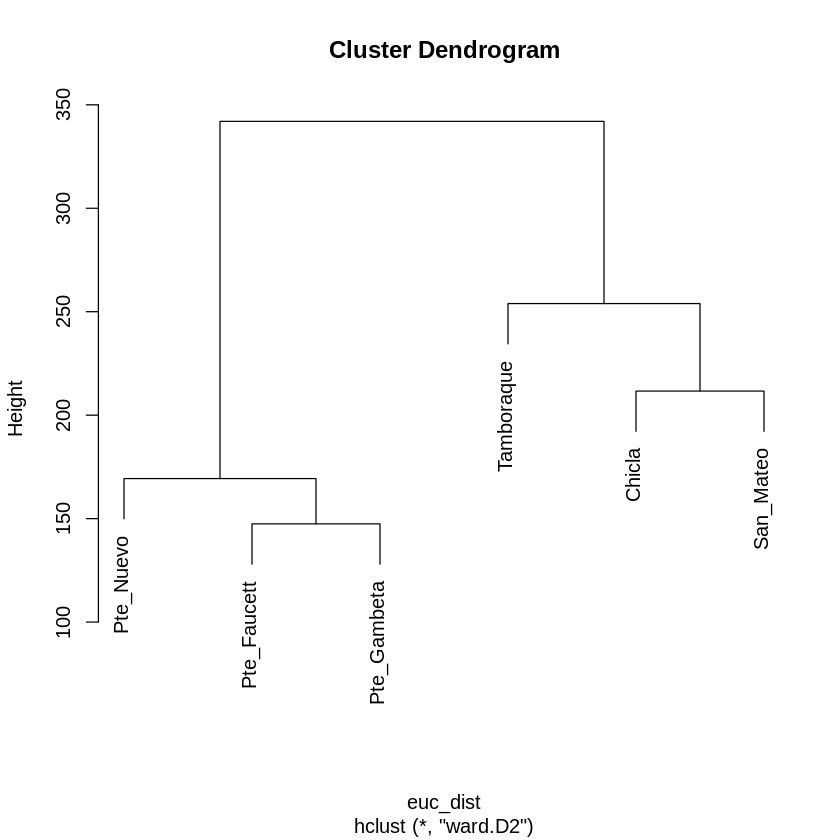

In [37]:
euc_dist <- dist(t(vst_trans_count_tab))
euc_clust <- hclust(euc_dist, method="ward.D2")
plot(euc_clust)

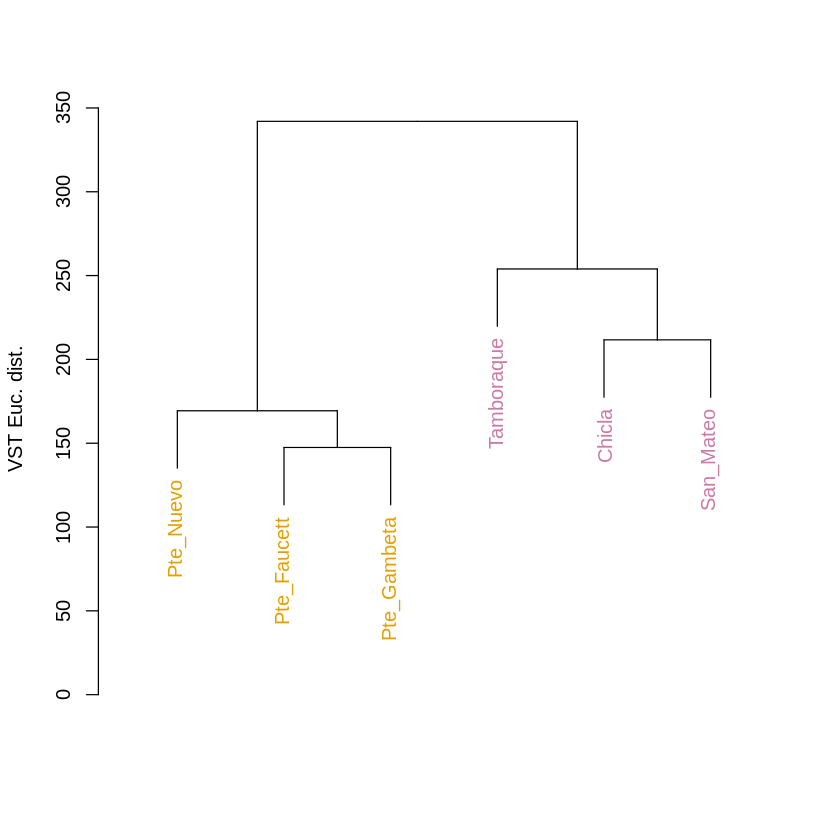

In [38]:
euc_dend <- as.dendrogram(euc_clust, hang=0.1)
dend_cols <- as.character(sample_info_tab$color_Lima[order.dendrogram(euc_dend)])
labels_colors(euc_dend) <- dend_cols
plot(euc_dend, ylab="VST Euc. dist.")

In [39]:
#create a phyloseq object using a normalized deseq table
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
sample_info_tab_phy <- sample_data(sample_info_tab)
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)
#create a PCOA
vst_pcoa <- ordinate(vst_physeq, method="MDS", distance="euclidean")
eigen_vals <- vst_pcoa$values$Eigenvalues 
write.table(vst_pcoa$vectors, "MDS.tab")
write.table(vst_pcoa$values, "MDS_values.tab")

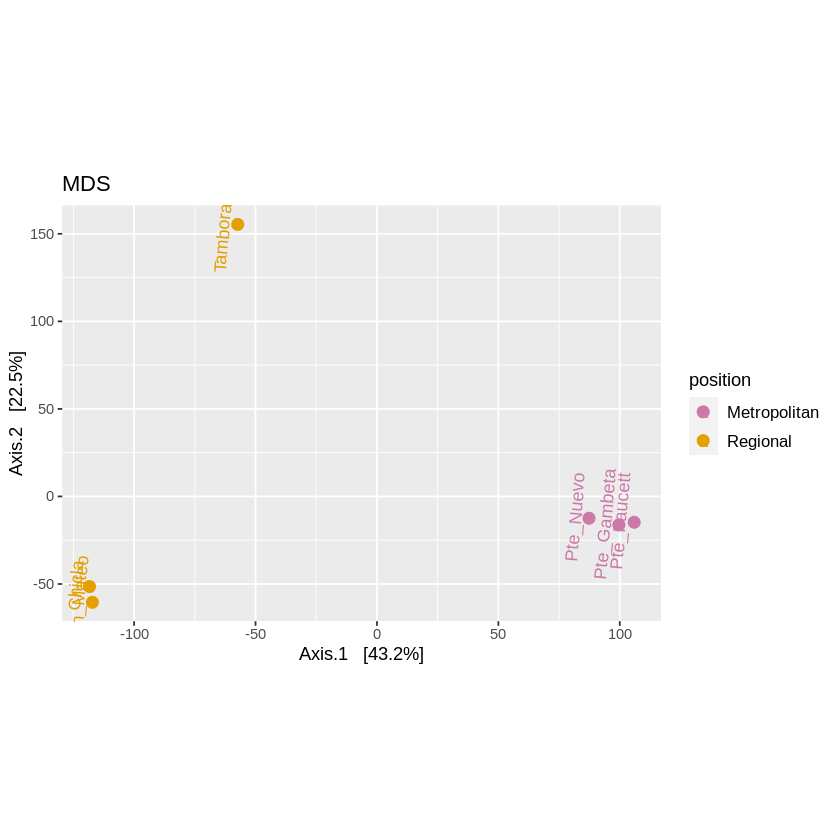

In [40]:
pco <- plot_ordination(vst_physeq, vst_pcoa, color="position") + 
  geom_point(size=3) + labs(col="position") + 
  geom_text(aes(label=rownames(sample_info_tab), hjust=+0.5, vjust=-0.6, angle = 85)) + 
  coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + ggtitle("MDS") + 
  scale_color_manual(values=unique(sample_info_tab$color_Lima)) + 
  theme(legend.text = element_text(size=10))
pco

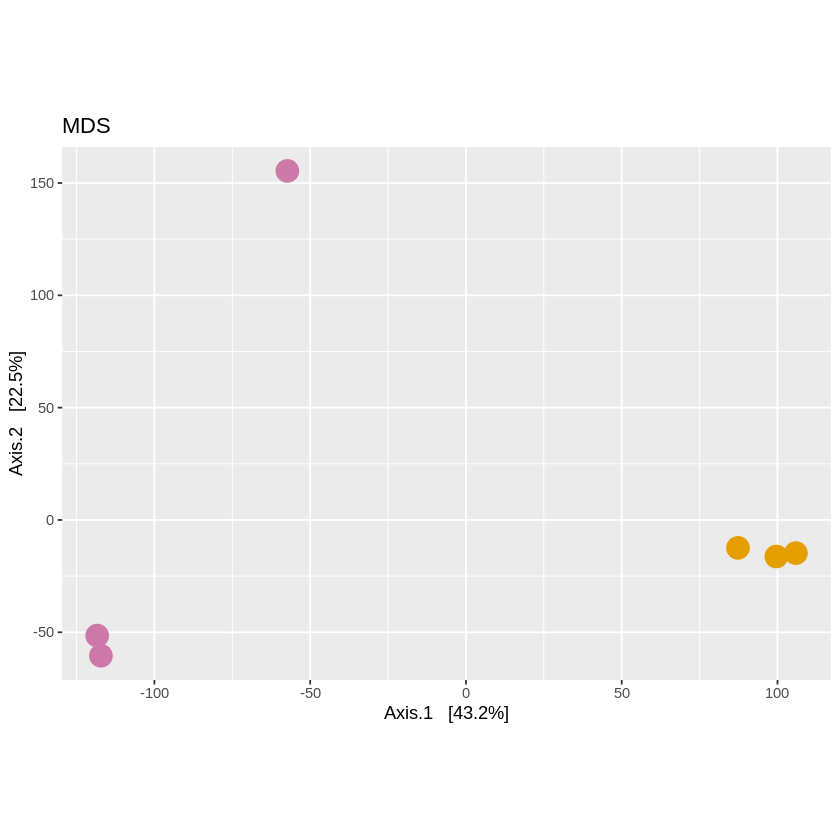

In [41]:
plot_ordination(vst_physeq, vst_pcoa, color="position") + 
  geom_point(size=6) + labs(col="Location") + 
    coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + ggtitle("MDS") + 
  scale_color_manual(values=unique(sample_info_tab$color_Lima[order(sample_info_tab$position)])) + 
  theme(legend.position="none")

In [42]:
count_tab_phy <- otu_table(count_tab, taxa_are_rows=T)
tax_tab_phy <- tax_table(tax_tab_sp)
ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)
ASV_physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3039 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 3039 taxa by 7 taxonomic ranks ]

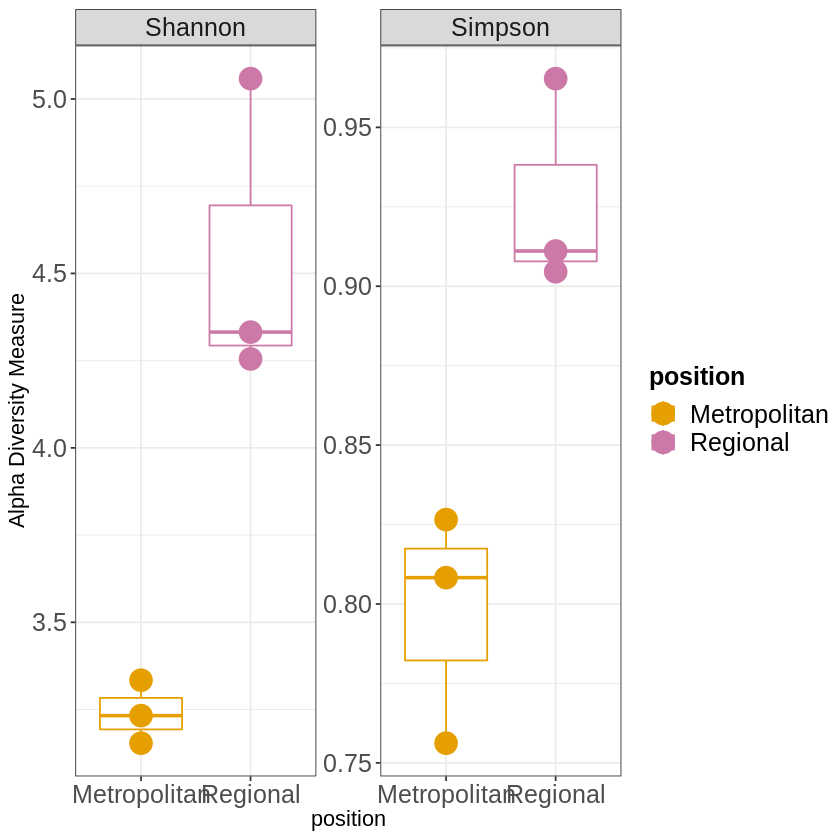

In [43]:
plot_richness(ASV_physeq, x="position", color="position", measures=c("Shannon", "Simpson")) + geom_boxplot() +
  scale_color_manual(values=unique(sample_info_tab$color_Lima[order(sample_info_tab$position)])) +
  theme_bw() + geom_point(size = 6) + theme(strip.text.x = element_text(size=15)) +
  theme(axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13)) +
  theme(axis.text.x = element_text(size = 15), 
        axis.text.y = element_text(size = 15)) + 
  theme(legend.title = element_text(size=15, face="bold")) +
  theme(legend.text = element_text(size=15))

In [44]:
clases_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank="Class"))
clases_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank="Class"))[,3])
rownames(clases_counts_tab) <- as.vector(clases_tax_vec)
#unclassified2_tax_counts <- colSums(count_tab) - colSums(clases_counts_tab)
#clases_and_unidentified_counts_tab <- rbind(clases_counts_tab, "Unclassified"=unclassified2_tax_counts)
#clases_taxa_counts_tab <- clases_and_unidentified_counts_tab
clases_taxa_counts_tab <- clases_counts_tab
identical(colSums(clases_taxa_counts_tab), colSums(count_tab))

[1] FALSE

In [45]:
clases_taxa_proportions_tab <- apply(clases_taxa_counts_tab, 2, function(x) x/sum(x)*100)
temp_filt_clases_taxa_proportions_tab <- data.frame(clases_taxa_proportions_tab[apply(clases_taxa_proportions_tab, 1, max) > 5, ])
filtered2_proportions <- colSums(clases_taxa_proportions_tab) - colSums(temp_filt_clases_taxa_proportions_tab) 
filt_clases_taxa_proportions_tab <- rbind(temp_filt_clases_taxa_proportions_tab, "Other"=filtered2_proportions)
clases_stack <- filt_clases_taxa_proportions_tab
clases_stack$Major_Taxa <- row.names(clases_stack)
clases_stack.g <- gather(clases_stack, Sample, Proportion, -Major_Taxa)
datos_stack<-data.frame("Sample"=row.names(sample_info_tab), "char"=sample_info_tab$position, "color"=sample_info_tab$color_Lima, stringsAsFactors=F)                                   
write.csv(clases_stack.g, "clases_stack_g.csv")
clases_stack.g2 <- merge(clases_stack.g, datos_stack)    

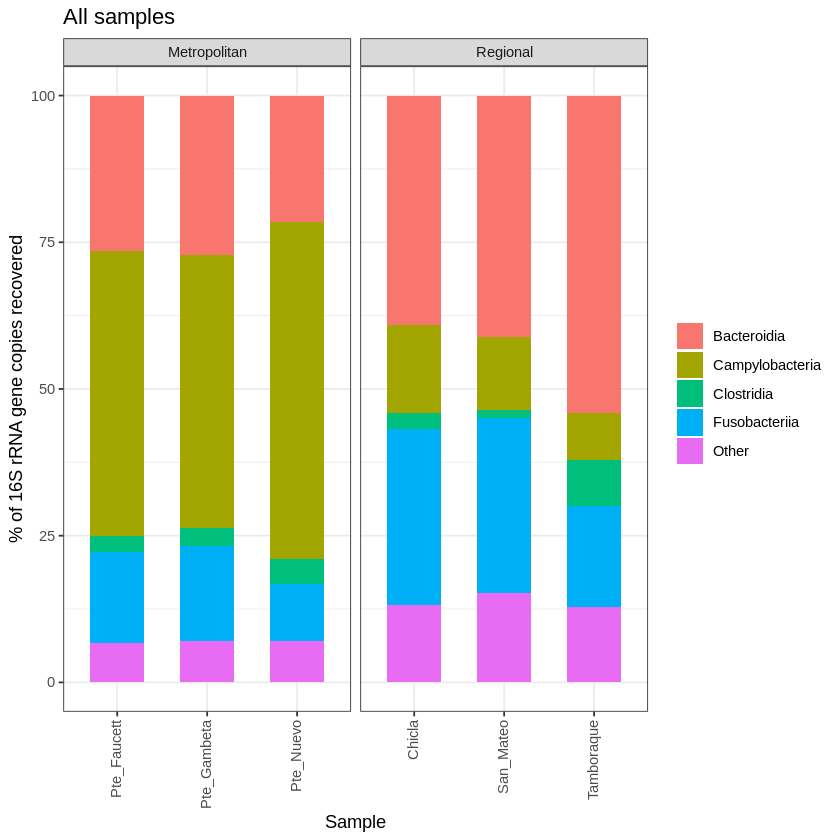

In [46]:
apilado <- ggplot(clases_stack.g2, aes(x=Sample, y=Proportion, fill=Major_Taxa)) +
  geom_bar(width=0.6, stat="identity") +
  theme_bw() +
  theme(axis.text.x=element_text(angle=90, vjust=0.4, hjust=1), legend.title=element_blank()) +
  labs(x="Sample", y="% of 16S rRNA gene copies recovered", title="All samples") +
 facet_grid(~char, scales = 'free_x', space = 'free_x')
apilado

In [47]:
library(ampvis2)
library(data.table)


Attaching package: ‘data.table’


The following object is masked from ‘package:dendextend’:

    set


The following object is masked from ‘package:SummarizedExperiment’:

    shift


The following object is masked from ‘package:GenomicRanges’:

    shift


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [48]:
otutable <- data.frame(OTU = rownames(phyloseq::otu_table(ASV_physeq)@.Data),
                       phyloseq::otu_table(ASV_physeq)@.Data,
                       phyloseq::tax_table(ASV_physeq)@.Data,
                       check.names = FALSE)
metadataX <- data.frame(phyloseq::sample_data(ASV_physeq), 
                       check.names = FALSE)
metadataX <-setDT(metadataX, keep.rownames = TRUE)[]

In [49]:
av2 <- amp_load(otutable, metadataX)

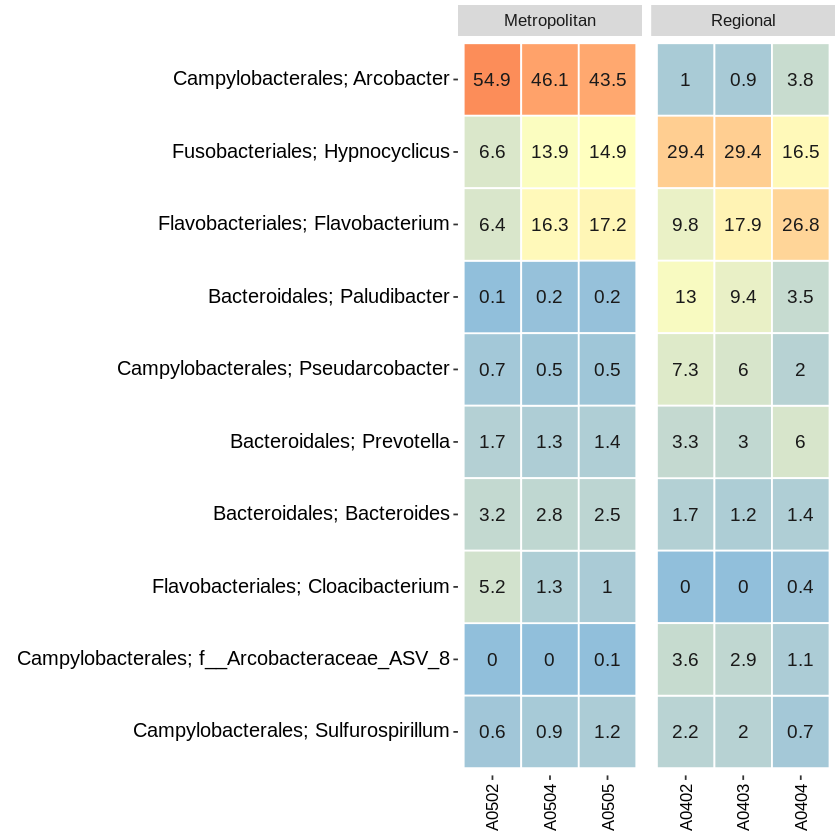

In [50]:
amp_heatmap(av2, 
            group_by = "sample_id", 
            facet_by = "position", 
            plot_values = TRUE,
            tax_show = 10,
            tax_aggregate = "Genus",
            tax_add = "Order",
            #color_vector = c("white","blue", "red"),
            plot_colorscale = "sqrt",
            plot_legendbreaks = c(1, 10, 30, 60))